# Импорты

In [46]:
import pandas as pd
import numpy as np
import sklearn
from pathlib import Path

## Дефолтные настройки Matplotlib

In [47]:
import matplotlib.pyplot as plt

# устанавливаем дефолтные размеры шрифтов
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Загрузка датасета

In [48]:
def load_data(path: Path):
    print("Read data set from path {path}".format(path=path))
    df = pd.read_csv(path)
    df["constraint1"] = df["constraint1"].astype('bool')
    df["constraint2"] = df["constraint2"].astype('bool')
    return df

Непосредственно загрузка

In [49]:
data_1_path = Path("data/DataSet900.csv")


data_1 = load_data(data_1_path)


dataset = data_1

Read data set from path data\DataSet900.csv


Шапка датасета, первые 5 записей  набора данных.

In [50]:
dataset.head()

,parameter1,parameter2,criteria1,criteria2,constraint1,constraint2
0,10,10,20,0.000,True,False
1,10,13,23,216.770,True,True
2,10,16,26,490.088,True,True
3,10,19,29,819.956,False,True
4,10,22,32,1206.370,False,True


Информация по колонкам

In [51]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   parameter1   900 non-null    int64  
 1   parameter2   900 non-null    int64  
 2   criteria1    900 non-null    int64  
 3   criteria2    900 non-null    float64
 4   constraint1  900 non-null    bool   
 5   constraint2  900 non-null    bool   
dtypes: bool(2), float64(1), int64(3)
memory usage: 30.0 KB


Основная статистическая информация по колонкам 

In [52]:
dataset.describe()

,parameter1,parameter2,criteria1,criteria2
count,900.000000,900.000000,900.000000,900.000000
mean,53.500000,53.500000,107.000000,0.000000
std,25.980762,25.980762,36.742346,12637.603925
min,10.000000,10.000000,20.000000,-29245.100000
25%,31.000000,31.000000,80.000000,-8574.190000
50%,53.500000,53.500000,107.000000,0.000000
75%,76.000000,76.000000,134.000000,8574.190000
max,97.000000,97.000000,194.000000,29245.100000


Количество встречающихся значений `constraint1`

In [53]:
dataset["constraint1"].value_counts()

constraint1
True     662
False    238
Name: count, dtype: int64

Количество встречающихся значений `constraint2`

In [54]:
dataset["constraint2"].value_counts()

constraint2
False    465
True     435
Name: count, dtype: int64

Код описывающий сохранение графиков и рисунков

In [55]:
IMAGES_PATH = Path('imgs/')
DATA_PATH = Path('data/')
MODEL_PATH = Path('saved_model/')

IMAGES_PATH.mkdir(parents=True, exist_ok=True)
DATA_PATH.mkdir(parents=True, exist_ok=True)
MODEL_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Представление о данных.
- по вертикали количество повторений
- по горизонтали величина значений

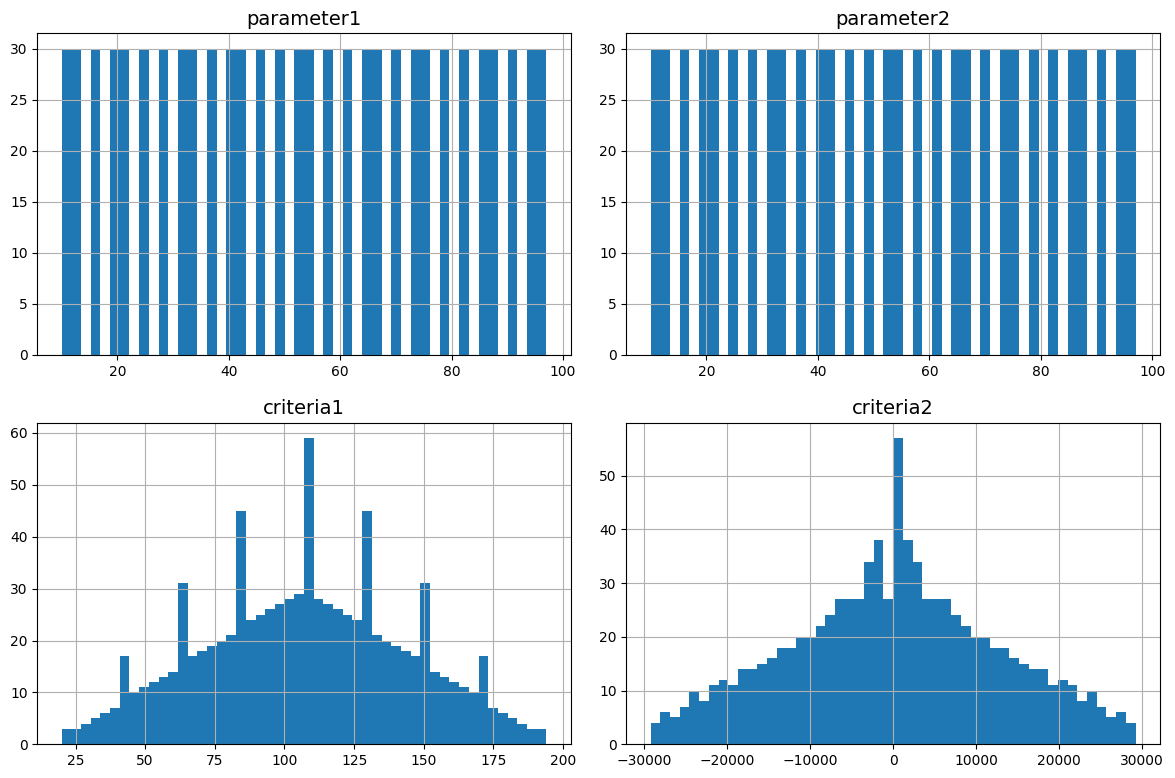

In [56]:
dataset.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

Устанавливаем параметр рандомизации (что бы значения повторялись при запуске)

In [57]:
np.random.seed(30)

Создание испытательного набора вручную, более подробно можно ознакомиться в книге...

In [58]:
def shuffle_and_split_data(data:  pd.DataFrame, test_ratio: float) -> (pd.DataFrame, pd.DataFrame):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

Более подходящий вариант, с использованием готовых инструментов.

In [59]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=30)

Какой то новый параметр, связан со стратификацией...
Мо создаём новый параметр на основе имеющихся данных, т.е. делим по группам criteria1 в диапазоне bins (лист)

In [60]:
dataset["criteria1_cut"] = pd.cut(dataset["criteria1"],
                               bins=[0, 80, 100, 120, 150, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [61]:
dataset.head()

,parameter1,parameter2,criteria1,criteria2,constraint1,constraint2,criteria1_cut
0,10,10,20,0.000,True,False,1
1,10,13,23,216.770,True,True,1
2,10,16,26,490.088,True,True,1
3,10,19,29,819.956,False,True,1
4,10,22,32,1206.370,False,True,1


Визуализируем нашу выборку

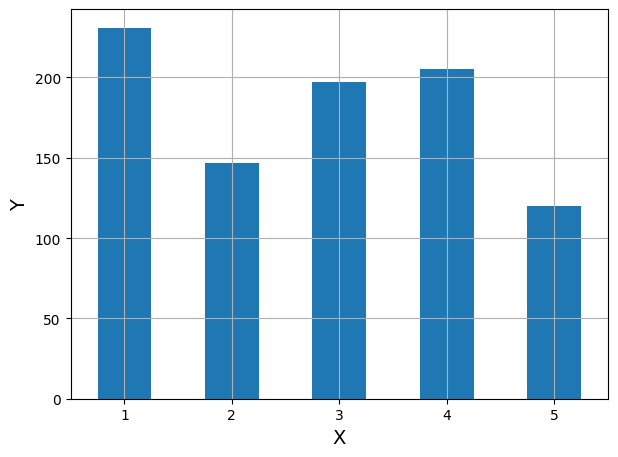

In [62]:
dataset["criteria1_cut"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("X")
plt.ylabel("Y")
save_fig("criteria1_cut_bar_plot")  # extra code
plt.show()

Если данные не равномерны, можно использовать стратифицированную выборку, а также можно объединять категории и группы.

In [63]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=30)
strat_splits = []
for train_index, test_index in splitter.split(dataset, dataset["criteria1_cut"]):
    strat_train_set_n = dataset.iloc[train_index]
    strat_test_set_n = dataset.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [64]:
strat_train_set, strat_test_set = strat_splits[1]
strat_test_set["criteria1_cut"].value_counts() / len(strat_test_set)

criteria1_cut
1    0.255556
4    0.227778
3    0.222222
2    0.161111
5    0.133333
Name: count, dtype: float64

Но проще так:

In [65]:
strat_train_set, strat_test_set = train_test_split(
    dataset, test_size=0.2, stratify=dataset["criteria1_cut"], random_state=30)

In [66]:
strat_test_set["criteria1_cut"].value_counts() / len(strat_test_set)

criteria1_cut
1    0.255556
4    0.227778
3    0.222222
2    0.161111
5    0.133333
Name: count, dtype: float64

После стратификации можно удалить этот атрибут
Удаляем новый атрибут.

In [67]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("criteria1_cut", axis=1, inplace=True)
    


# Тренировочный датасет

In [68]:
train_data = strat_train_set.copy()
test_data = strat_test_set.copy()

In [69]:
train_data.head()

,parameter1,parameter2,criteria1,criteria2,constraint1,constraint2
681,76,73,149,-1404.29,True,False
890,97,70,167,-14165.40,True,False
239,31,97,128,26540.20,False,True
30,13,10,23,-216.77,True,False
39,13,37,50,3769.91,False,True


# Визуализация критериев тренировочного набора

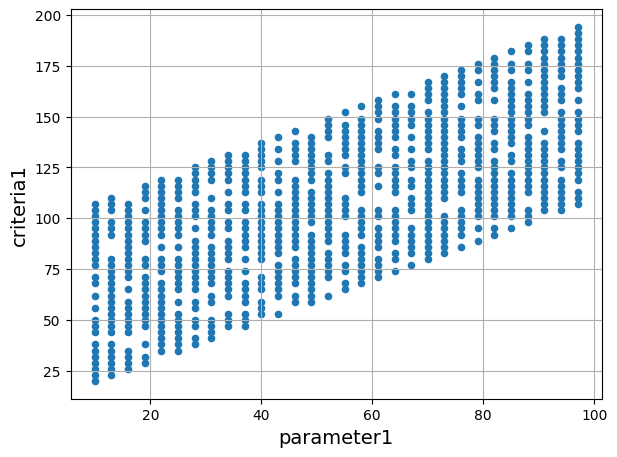

In [70]:
train_data.plot(kind="scatter", x="parameter1", y="criteria1", grid=True)
save_fig("bad_visualization_plot")  # extra code
plt.show()

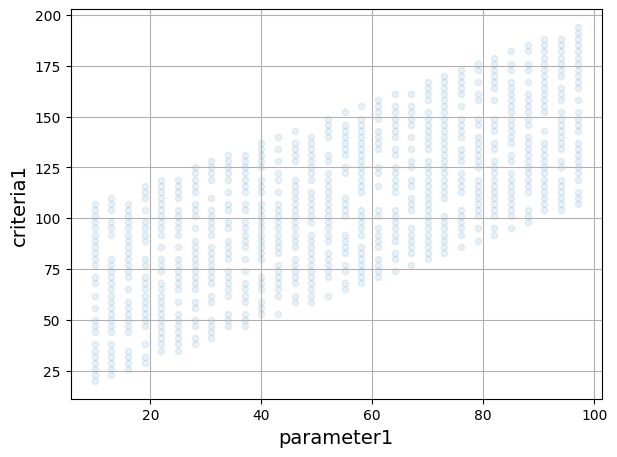

In [71]:
train_data.plot(kind="scatter", x="parameter1", y="criteria1", grid=True, alpha=0.1)
save_fig("better_visualization_plot")  # extra code
plt.show()

d:\Projects\NLP_course\.venv\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


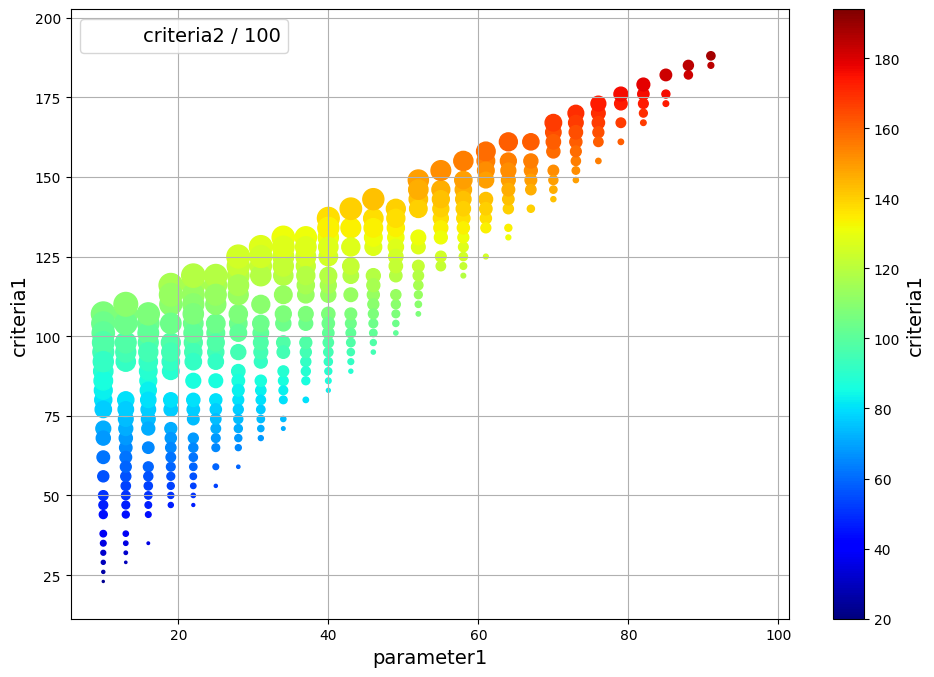

In [72]:
train_data.plot(kind="scatter", x="parameter1", y="criteria1", grid=True,
             s=train_data["criteria2"] / 100, label="criteria2 / 100",
             c="criteria1", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
save_fig("some_plot_scatterplot")  # extra code
plt.show()

## Корреляция параметров

In [73]:
corr_matrix = train_data.corr()
corr_matrix

,parameter1,parameter2,criteria1,criteria2,constraint1,constraint2
parameter1,1.000000,0.000118,0.709771,-0.694060,0.651685,-0.582019
parameter2,0.000118,1.000000,0.704516,0.688767,-0.376037,0.572240
criteria1,0.709771,0.704516,1.000000,-0.007376,0.197600,-0.009947
criteria2,-0.694060,0.688767,-0.007376,1.000000,-0.673201,0.798630
constraint1,0.651685,-0.376037,0.197600,-0.673201,1.000000,-0.615822
constraint2,-0.582019,0.572240,-0.009947,0.798630,-0.615822,1.000000


Корреляция определенного параметра

In [74]:
corr_matrix["criteria1"].sort_values(ascending=False)

criteria1      1.000000
parameter1     0.709771
parameter2     0.704516
constraint1    0.197600
criteria2     -0.007376
constraint2   -0.009947
Name: criteria1, dtype: float64

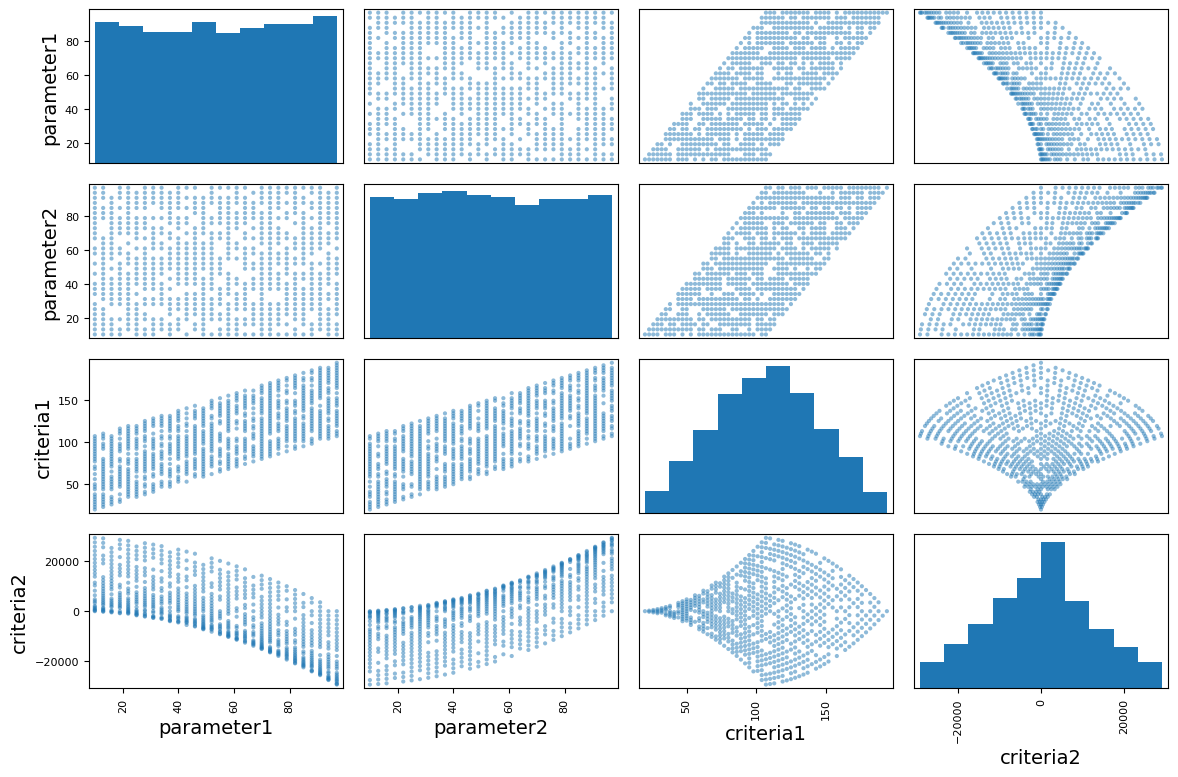

In [75]:
from pandas.plotting import scatter_matrix

attributes = ["parameter1", "parameter2", "criteria1",
              "criteria2"]
scatter_matrix(train_data[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

Можно поближе рассмотреть определённый график

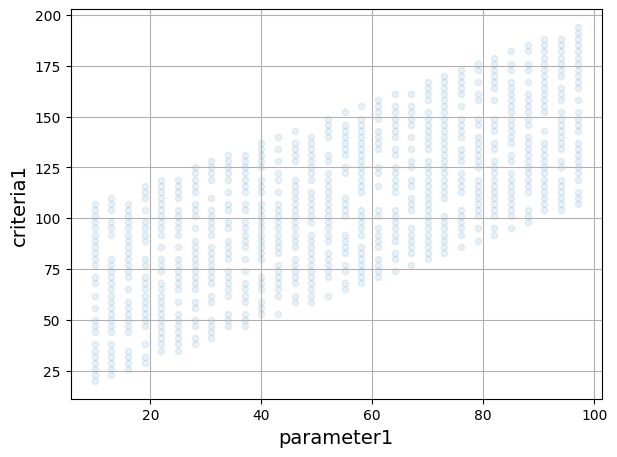

In [76]:
train_data.plot(kind="scatter", x="parameter1", y="criteria1",
             alpha=0.1, grid=True)
save_fig("parameter1_vs_criteria1_scatterplot")  # extra code
plt.show()

## Эксперименты с атрибутами

In [77]:
train_data["criteria2_parameter1"] = train_data["criteria2"] / train_data["parameter1"]
train_data["criteria2_parameter2"] = train_data["criteria2"] / train_data["parameter2"]
train_data["parameter1_parameter2"] = train_data["parameter1"] * train_data["parameter2"]

corr_matrix = train_data.corr()
corr_matrix["criteria1"].sort_values(ascending=False)

criteria1                1.000000
parameter1_parameter2    0.944658
parameter1               0.709771
parameter2               0.704516
constraint1              0.197600
criteria2_parameter2     0.057293
criteria2               -0.007376
constraint2             -0.009947
criteria2_parameter1    -0.065480
Name: criteria1, dtype: float64

Новый критерий сильно коррелирует с нашим параметром

# Чистовой вариант датасета

In [78]:
train_data = strat_train_set.drop("criteria1", axis=1)
train_data_labels = strat_train_set["criteria1"].copy()

train_data.head()

,parameter1,parameter2,criteria2,constraint1,constraint2
681,76,73,-1404.29,True,False
890,97,70,-14165.40,True,False
239,31,97,26540.20,False,True
30,13,10,-216.77,True,False
39,13,37,3769.91,False,True


In [79]:
train_data_labels.head()

681    149
890    167
239    128
30      23
39      50
Name: criteria1, dtype: int64

## Очистка данных
### Устранение пустых значений как пример...
Предположим у нас в `criteria2` есть пустые значения
Варианты:
- избавиться от соответствующих округов; 
- избавиться от всего атрибута; 
- установить недостающие значения в некоторую величину	

```python
train_data.dropna(subset=["criteria2"], inplace=True)

train_data.drop("criteria2", axis=1)

median = train_data["criteria2"].median()
train_data["criteria2"].fillna(median, inplace=True)
```

Можно использовать класс `sklearn.impute`:

In [80]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Посмотреть на элементы с нулевыми значениями

In [81]:
null_rows_idx = train_data.isnull().any(axis=1)
train_data.loc[null_rows_idx].head()

,parameter1,parameter2,criteria2,constraint1,constraint2


Объект `imputer` не может взаимодействовать с не числовыми данными, поэтому надо скопировать датасет только с цифровыми признаками.

In [82]:
data_input_number = train_data.select_dtypes(include=[np.number])

Ну и сам процесс замены

In [83]:
imputer.fit(data_input_number)

SimpleImputer(strategy='median')

Данные о данном объекте

In [84]:
imputer.statistics_

array([55., 52.,  0.])

In [85]:
data_input_number.median().values

array([55., 52.,  0.])

Трансформация тренировочного набора

In [86]:
X = imputer.transform(data_input_number)

In [87]:
imputer.feature_names_in_

array(['parameter1', 'parameter2', 'criteria2'], dtype=object)

In [88]:
data_input_tr_example = pd.DataFrame(X, columns=data_input_number.columns,
                          index=data_input_number.index)

проверка

In [89]:
data_input_tr_example.loc[null_rows_idx].head()

,parameter1,parameter2,criteria2


Стратегия

In [90]:
imputer.strategy

'median'

## Обработка текстовых и категориальных атрибутов
Смотреть в книге

## Масштабирование значений
Масштабируем по min max (нормализация)

In [91]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(data_input_number)
housing_num_min_max_scaled


array([[ 0.51724138,  0.44827586, -0.04801796],
       [ 1.        ,  0.37931034, -0.48436832],
       [-0.51724138,  1.        ,  0.90750929],
       ...,
       [ 0.17241379,  0.17241379,  0.        ],
       [ 0.37931034, -0.44827586, -0.40219045],
       [ 0.17241379, -0.44827586, -0.27553983]])

In [92]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(data_input_number)
housing_num_std_scaled

array([[ 0.84498765,  0.75371785, -0.09569887],
       [ 1.64520143,  0.63854874, -1.0983291 ],
       [-0.86975617,  1.67507074,  2.09987743],
       ...,
       [ 0.27340638,  0.29304141,  0.01463508],
       [ 0.61635514, -0.7434806 , -0.90950374],
       [ 0.27340638, -0.7434806 , -0.61849048]])

# Кастомный трансформатор
Далее пример логарифмов...

In [93]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(data_input_number[["criteria2"]])
log_pop.head()

d:\Projects\NLP_course\.venv\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
d:\Projects\NLP_course\.venv\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,criteria2
681,NaN
890,NaN
239,10.186416
30,NaN
39,8.234806


Трансформатор, который вычисляет ту же гауссову
меру подобия RBF

In [94]:
from sklearn.metrics.pairwise import rbf_kernel

rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[0]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(data_input_number[["criteria2"]])
age_simil_35[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

# Pipelines трансформации

In [95]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

Второй вариант

In [96]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

Описание pipeline

In [97]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

Преобразования над данными

In [98]:
train_data_num_prepared = num_pipeline.fit_transform(data_input_number)
train_data_num_prepared[:2].round(2)

array([[ 0.84,  0.75, -0.1 ],
       [ 1.65,  0.64, -1.1 ]])

Формируем в очередной раз датасет через пайплайн

In [99]:
df_train_data_num_prepared = pd.DataFrame(
    train_data_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=data_input_number.index)
df_train_data_num_prepared.head(2)  # extra code

,parameter1,parameter2,criteria2
681,0.844988,0.753718,-0.095699
890,1.645201,0.638549,-1.098329


Трансформер для бинарных данных

In [100]:
from sklearn.preprocessing import Binarizer
from sklearn.compose import ColumnTransformer

num_attribs = ["parameter1", "parameter2", "criteria2"]

bin_attribs = ["constraint1", "constraint2"]

bin_pipeline = make_pipeline(Binarizer())

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", bin_pipeline, bin_attribs),
])

Сборка в один трансформер

In [101]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (bin_pipeline, make_column_selector(dtype_include=np.bool_)),
)
train_data_prepared = preprocessing.fit_transform(train_data)

Сборка датасета

In [102]:
# extra code – shows that we can get a DataFrame out if we want
data_prepared_fr = pd.DataFrame(
    train_data_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=train_data.index)
data_prepared_fr.head(4)

,pipeline-1__parameter1,pipeline-1__parameter2,pipeline-1__criteria2,pipeline-2__constraint1,pipeline-2__constraint2
681,0.844988,0.753718,-0.095699,1.0,0.0
890,1.645201,0.638549,-1.098329,1.0,0.0
239,-0.869756,1.675071,2.099877,0.0,1.0
30,-1.555654,-1.664833,-0.002396,1.0,0.0


In [103]:
train_data.head(2)

,parameter1,parameter2,criteria2,constraint1,constraint2
681,76,73,-1404.29,True,False
890,97,70,-14165.40,True,False


In [104]:
train_data_labels.head(2)

681    149
890    167
Name: criteria1, dtype: int64

# Создаём модель и обучаем

Обучаем на 4 строках датасета, так как уже точность почти 100% `size_butch = 4``
`

In [105]:
from sklearn.linear_model import LinearRegression

# lin_reg = make_pipeline(preprocessing, LinearRegression())

lin_reg = LinearRegression()

size_butch = 4

lin_reg.fit(train_data[:size_butch], train_data_labels[:size_butch])

LinearRegression()

Тестовый датасет значений

In [106]:
test_data_value = test_data.drop("criteria1", axis=1)
test_data_value.head()

,parameter1,parameter2,criteria2,constraint1,constraint2
846,94,28,-25296.10,True,False
116,19,88,23194.40,False,True
300,40,10,-4712.39,True,False
74,16,52,7690.62,False,True
11,10,43,5494.65,False,True


Тестовый датасет меток

In [107]:
test_data_labels = test_data["criteria1"].copy()
test_data_labels.head()

846    122
116    107
300     50
74      68
11      53
Name: criteria1, dtype: int64

Сравнение предиктов и меток

In [108]:
some_predictions = lin_reg.predict(test_data_value)
print(some_predictions[:5])
print(test_data_labels[:5])

[121.99537328 107.00265856  49.99484447  68.0019095   53.00230608]
846    122
116    107
300     50
74      68
11      53
Name: criteria1, dtype: int64


Отклонение идивидуальное 

In [109]:
# extra code – computes the error ratios discussed in the book
error_ratios = some_predictions[:5] / test_data_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-0.0%, 0.0%, -0.0%, 0.0%, 0.0%


# СКО модели

In [110]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(test_data_labels, some_predictions,
                              squared=False)
lin_rmse

d:\Projects\NLP_course\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.0027547709667266993

# Сохранение модели

In [111]:
import pickle

# Save to file in the current working directory 
pkl_filename = "saved_model/lin_reg.pkl" 
with open(pkl_filename, 'wb') as file: 
    pickle.dump(lin_reg, file) 

# Загрузка модели

In [112]:
# Load from file 
with open(pkl_filename, 'rb') as file: 
    pickle_model = pickle.load(file)

some_predictions = pickle_model.predict(test_data_value)
print(some_predictions[:5])
print(test_data_labels[:5])

[121.99537328 107.00265856  49.99484447  68.0019095   53.00230608]
846    122
116    107
300     50
74      68
11      53
Name: criteria1, dtype: int64
